# Mult-VAE

- [Variational Autoencoders for Collaborative Filtering](https://arxiv.org/pdf/1802.05814.pdf)

## Experiment

- sampling vs training all
     - sampling이 일반적으로 성능이 좋음
- alternative learning
    - alternative learning으로 성능 향상
- multinomial vs logistic
    - alternative learning을 적용하지 않으면 logistic의 성능이 더 좋았음
    - alternative learning을 적용하게 되면 multinomial의 성능이 더 좋아짐
- Mult-VAE vs Mult-DAE
    - ML-1M에서는 Mult-DAE 성능이 더 높았음

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple, List
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''

    if data_size == '1m':
        fname = 'ml-1m.zip'
        data = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        fname = 'ml-10m.zip'
        data = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        fname = 'ml-20m.zip'
        data = 'ml-20m/ratings.csv'
    elif data_size == '25m':
        fname = 'ml-25m.zip'
        data = 'ml-25m/ratings.csv'
    if not glob.glob(data):
        origin = f'http://files.grouplens.org/datasets/movielens/{fname}'
        file = get_file(fname, origin)
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    if data_size in ['20m', '25m']:
        ratings = pd.read_csv(data, engine = 'python')
    else:
        ratings = pd.read_csv(data, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
n_user = ratings.userId.nunique()
print(f'# of user = {n_user}')

n_item = ratings.movieId.nunique()
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [5]:
def train_valid_test_split(df: pd.DataFrame) -> pd.DataFrame:
    train_user, test_user = train_test_split(df.userId.unique(), test_size = 0.2, random_state = 777)
    valid_user, test_user = train_test_split(test_user, test_size = 0.5, random_state = 777)

    train, valid, test = map(lambda x: df[df.userId.isin(x)], (train_user, valid_user, test_user))
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

def query_answer_split(df: pd.DataFrame) -> pd.DataFrame:
    timeorder = df.groupby(by = 'userId')['timestamp'].rank(method = 'first', ascending = True)
    seen_cnts = df.groupby(by = 'userId', as_index = False).agg(seen_cnts = ('movieId', 'count'))
    df = df.merge(seen_cnts, how = 'left', on = 'userId')
    df = df.assign(timeorder = timeorder)
    df = df.assign(split_type = np.where(df.timeorder < df.seen_cnts * 0.8, 'query', 'answer'))
    query = df[df.split_type == 'query']
    answer = df[df.split_type == 'answer']
    answer = answer[answer.userId.isin(query.userId.unique())]
    query, answer = map(lambda df: df.drop(columns = ['timeorder', 'seen_cnts', 'split_type']), (query, answer))
    query, answer = map(lambda df: df.reset_index(drop = True), (query, answer))
    return query, answer

def cut_off(df: pd.DataFrame, threshold = 4) -> pd.DataFrame:
    return df[df.rating >= threshold].reset_index(drop = True)

def make_warm(df: pd.DataFrame, threshold = 5) -> pd.DataFrame: # remove cold starters
    positive = df.groupby('userId')['movieId'].nunique()
    positive = positive.index[positive >= threshold]
    return df[df.userId.isin(positive)].reset_index(drop = True)

def list_aggregation(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [6]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [7]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [8]:
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(1000209, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [13]:
def train_generator(df: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    sampling = True,
                    NS = 5) -> Tuple:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']

    n_batch = int(np.ceil(n_row / batch_size))
    if sampling:
        while True:
            batch_Id = np.random.choice(Ids, size = batch_size)
            batch = np.zeros(shape = (batch_size, n_col))
            
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                batch[i, pos] = 1.0

            yield batch, batch
    else:
        while True:
            np.random.shuffle(Ids)
        
            for batch_step in range(n_batch):
                lower = batch_step * batch_size
                upper = lower + batch_size
                
                batch_Id = Ids[lower: upper]
                batch = np.zeros(shape = (batch_Id.size, n_col))
                for i, idx in enumerate(batch_Id):
                    pos = np.array(profile[idx])
                    batch[i, pos] = 1.0             
                yield batch, batch

In [14]:
def valid_generator(query: pd.DataFrame,
                    answer: pd.DataFrame,
                    n_item: int,
                    batch_size: int) -> Tuple:

    n_row = query.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile_q = query['movieId']
    profile_a = answer['movieId']

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch_q = np.zeros(shape = (batch_Id.size, n_col))
            batch_a = np.zeros(shape = (batch_Id.size, n_col))

            for i, idx in enumerate(batch_Id):
                obs = np.array(profile_q[idx]) # observed
                ubs = np.array(profile_a[idx]) # unobserved

                batch_q[i, obs] = 1.0
                batch_a[i, ubs] = 1.0
                batch_a[i, obs] = -1.0 # to mark seen-data

            yield batch_q, batch_a

In [15]:
def mae(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    ae = K.abs(y_true - y_pred)
    return K.mean(ae, axis = -1)

def rmse(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    se = K.square(mask_true * (y_true - y_pred))
    return K.sqrt(K.mean(masked_se, axis = -1))

def cross_entropy(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    ce = y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1. - y_pred)
    return -K.sum(ce, axis = -1)

def log_loss(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    return -K.sum(y_true * K.log(y_pred), axis = -1)

def batch_ndcg(y_true, y_pred, k = 100): # only for validation
    rec = tf.where(y_true == -1.0, -1.0, y_pred) # leave only unseen-data
    rec = tf.argsort(rec, axis = -1, direction = 'DESCENDING')[:, :k]

    row = tf.repeat(tf.range(tf.shape(y_true)[0]), k)
    row = tf.expand_dims(row, axis = 1)
    col = tf.reshape(rec, shape = [-1])
    col = tf.expand_dims(col, axis = 1)
    loc = tf.concat([row, col], axis = 1)

    top_k = tf.reshape(tf.gather_nd(y_true, loc), shape = tf.shape(rec))
    ideal = tf.sort(y_true, axis = 1, direction = 'DESCENDING')[:, :k]

    weight = tf.range(2, 102, dtype = 'float32')
    weight = tf.math.log(weight)
    weight = tf.math.reciprocal(weight)
    
    dcg = tf.reduce_sum(top_k * weight, axis = 1)    
    idcg = tf.reduce_sum(tf.where(ideal == -1.0, 0.0, ideal * weight), axis = 1)
    return dcg / tf.where(idcg == 0.0, 1.0, idcg)

In [16]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        return z_mean + K.exp(0.5 * z_log_var) * K.random_normal(shape = (batch, dim))

In [17]:
def VAE(n_user: int,
        n_item: int,
        latent_dim = 200,
        activation = 'tanh',
        enc_optimizer = 'adam',
        optimizer = 'adam',
        dropout_rate = 0.5,
        kernel_initializer = None,
        likelihood = 'logistic',
        beta = 0.2) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)

    if likelihood == 'multinomial':
        loss = log_loss
        last_activation = 'softmax'
    elif likelihood == 'logistic':
        loss = cross_entropy
        last_activation = 'sigmoid'
    elif likelihood == 'gaussian':
        loss = rmse
        last_activation = 'linear'
    
    inputs = Input(shape = (n_item, ), name = 'input')
    z_mean_weight = Dense(latent_dim,
                          activation = activation,
                          kernel_initializer = kernel_initializer,
                          name = 'mean')
    z_log_var_weight = Dense(latent_dim, 
                             activation = activation,
                             kernel_initializer = kernel_initializer,
                             name = 'log_var')
    outputs_weight = Dense(n_item,
                           activation = last_activation, 
                           kernel_initializer = kernel_initializer,
                           name = 'output')

    x = Dropout(dropout_rate)(inputs)
    enc_z_mean = z_mean_weight(x)
    enc_z_log_var = z_log_var_weight(x)
    enc_z = Sampling()([enc_z_mean, enc_z_log_var])
    enc_KLD = -0.5 * K.sum(1 + enc_z_log_var - K.exp(enc_z_log_var) - K.square(enc_z_mean), axis = -1)
    encoder_loss = K.mean(enc_KLD, axis = -1)

    encoder = Model(inputs = inputs, outputs = [enc_z_mean, enc_z_log_var, enc_z], name = 'encoder')
    encoder.add_loss(encoder_loss)
    encoder.compile(optimizer = enc_optimizer)

    z_mean = z_mean_weight(inputs)
    z_log_var = z_log_var_weight(inputs)
    z = Sampling()([z_mean, z_log_var])
    outputs = outputs_weight(z)

    KLD = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1)
    MLE = loss(inputs, outputs)
    vae_loss = K.mean(MLE + beta * KLD, axis = -1)

    model = Model(inputs = inputs, outputs = outputs, name = 'VAE')
    model.add_loss(vae_loss)
    model.compile(optimizer = optimizer, metrics = [mae, batch_ndcg])
    return encoder, model

In [18]:
def test_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']

    pred = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = 1.0

        y_pred = model.predict(y_true, verbose = 0)
        
        cand = np.argsort(np.where(y_true == 1.0, -1.0, y_pred), axis = -1)[:, :-N-1:-1]
        pred.append(cand)
    pred = np.concatenate(pred)
    pred = [{'userId': df.at[i, 'userId'], 'movieId': pred[i]} for i in range(n_row)]
    return pd.DataFrame(pred)

In [19]:
def show_history(history, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(history[f'{loss}'])
    ax1.plot(history[f'val_{loss}'])
    ax1.set_title(loss, fontsize = 20)
    ax1.set_ylabel(loss)
    ax1.set_xlabel('epoch')
    ax1.legend([loss, f'val_{loss}'], loc = 'upper right')

    ax2.plot(history[f'{metric}'])
    ax2.plot(history[f'val_{metric}'])
    ax2.set_title(metric, fontsize = 20)
    ax2.set_ylabel(metric)
    ax2.set_xlabel('epoch')
    ax2.legend([metric, f'val_{metric}'], loc = 'upper right')
    plt.show()

In [20]:
class evaluate:
    def __init__(self, true: pd.DataFrame, pred: pd.DataFrame):
        self.true = true
        self.pred = pred
        self.max_K = 10000
        self.idcg = np.cumsum([1.0 / np.log(i+2) for i in range(self.max_K)])

    def _recall(self, gt: List, rec: List, K = None) -> float:
        K = K if K else self.max_K
        res = [r for r in rec[:K] if r in gt]
        return len(res) / np.min([K, len(gt)])
    
    def _precision(self, gt: List, rec: List, K = None) -> float:
        K = K if K else self.max_K
        res = [r for r in rec[:K] if r in gt]
        return len(res) / len(rec[:K])

    def _AP(self, gt: List, rec: List, K = None) -> float: # Average Precision
        K = K if K else self.max_K
        res = 0
        for i, r in enumerate(rec[:K]):
            if r in gt:
                res += self._precision(gt, rec[:K], i+1)
        return res / np.min([K, len(gt)])

    def _RR(self, gt: List, rec: List, K = None) -> float: # Reciprocal Rank
        K = K if K else self.max_K
        for i, r in enumerate(rec[:K]):
            if r in gt:
                return  1.0 / (i+1)
        return 0

    def _nDCG(self, gt: List, rec: List, K = None) -> float: # normalized Discounted Cumulative Gain
        K = K if K else self.max_K
        dcg = 0.0
        for i, r in enumerate(rec[:K]):
            if r in gt:
                dcg += 1.0 / np.log(i+2)
        idcg = self.idcg[min([len(gt), K])-1]
        return dcg / idcg
    
    def __call__(self, K = None):
        self.K = K
        self.recall = 0
        self.precision = 0
        self.MAP = 0
        self.MRR = 0
        self.nDCG = 0
        n = self.true.index.size
        for gt, rec in zip(tqdm(self.true.movieId), self.pred.movieId):
            self.recall += self._recall(gt, rec, K) / n
            self.precision += self._precision(gt, rec, K) / n
            self.MAP += self._AP(gt, rec, K) / n
            self.MRR += self._RR(gt, rec, K) / n
            self.nDCG += self._nDCG(gt, rec, K) / n

    def print_all(self):
        K = '@' + str(self.K) if self.K else ''
        print(f'{"Recall":>12}{K} : {self.recall:.5f}',
              f'\n{"Precision":>12}{K} : {self.precision:.5f}',
              f'\n{"MAP":>12}{K} : {self.MAP:.5f}',
              f'\n{"nRR":>12}{K} : {self.MRR:.5f}',
              f'\n{"nDCG":>12}{K} : {self.nDCG:.5f}')

### 1. Mult-DAE(Multinomial Likelihood)

In [21]:
ratings = cut_off(ratings)

train, valid, test = train_valid_test_split(ratings)
train = make_warm(train)
train = list_aggregation(train)

(valid_q, valid_a), (test_q, test_a) = map(query_answer_split, (valid, test))
valid_q, valid_a, test_q, test_a = map(list_aggregation, (valid_q, valid_a, test_q, test_a))

In [22]:
batch_size = 128

train_gen = train_generator(train, n_item, batch_size)
valid_gen = valid_generator(valid_q, valid_a, n_item, batch_size)

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid_q.index.size // batch_size + 1

In [23]:
enc_optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
encoder, model = VAE(n_user, n_item, latent_dim = 200, enc_optimizer = enc_optimizer, optimizer = optimizer, likelihood = 'multinomial')
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
sampling_1 (Sampling)           (None, 200)          0           mean[1][0]                       
                                                                 log_var[1][0]                  

In [24]:
%%time
epochs = 100
total_hist = {}
for _ in range(epochs):
    anneal_size, epoch_size = 4, 2
    encoder.fit(x = train_gen, epochs = anneal_size, steps_per_epoch = steps_per_epoch, verbose = 0)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epoch_size, verbose = 1,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps)
    for key in hist.history.keys():
        total_hist[key] = total_hist.get(key, []) + hist.history[key]

Epoch 1/2
38/38 [==============================] - 1s 19ms/step - loss: 749.3632 - mae: 0.0263 - batch_ndcg: 0.1951 - val_loss: 534.8777 - val_mae: 0.0247 - val_batch_ndcg: 0.1057
Epoch 2/2
38/38 [==============================] - 0s 10ms/step - loss: 688.8682 - mae: 0.0257 - batch_ndcg: 0.3431 - val_loss: 517.8611 - val_mae: 0.0247 - val_batch_ndcg: 0.1315
Epoch 1/2
38/38 [==============================] - 0s 11ms/step - loss: 710.1390 - mae: 0.0260 - batch_ndcg: 0.2833 - val_loss: 519.7021 - val_mae: 0.0247 - val_batch_ndcg: 0.1257
Epoch 2/2
38/38 [==============================] - 0s 10ms/step - loss: 705.0870 - mae: 0.0268 - batch_ndcg: 0.3942 - val_loss: 511.2372 - val_mae: 0.0247 - val_batch_ndcg: 0.1433
Epoch 1/2
38/38 [==============================] - 0s 11ms/step - loss: 711.1942 - mae: 0.0262 - batch_ndcg: 0.2943 - val_loss: 514.9510 - val_mae: 0.0247 - val_batch_ndcg: 0.1347
Epoch 2/2
38/38 [==============================] - 0s 10ms/step - loss: 688.5529 - mae: 0.0264 - bat

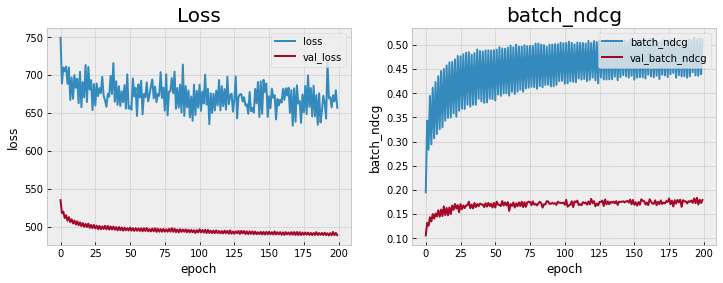

In [25]:
show_history(total_hist, 'loss', 'batch_ndcg')

In [26]:
pred = test_predictor(test_q, model, n_item, batch_size, N = 100)
pred.head(5)

,userId,movieId
0,4,"[524, 246, 305, 515, 38, 134, 167, 435, 343, 5..."
1,9,"[814, 19, 1256, 792, 828, 26, 676, 741, 400, 1..."
2,14,"[195, 128, 150, 264, 895, 97, 433, 39, 891, 12..."
3,44,"[134, 729, 400, 690, 412, 396, 171, 417, 381, ..."
4,59,"[273, 104, 5, 44, 22, 38, 352, 124, 788, 132, ..."


In [27]:
eval = evaluate(test_a, pred)

eval(K = 20)
eval.print_all()

eval(K = 100)
eval.print_all()


      Recall@20 : 0.12403 
   Precision@20 : 0.07409 
         MAP@20 : 0.03945 
         nRR@20 : 0.22175 
        nDCG@20 : 0.10753



      Recall@100 : 0.32824 
   Precision@100 : 0.05134 
         MAP@100 : 0.05225 
         nRR@100 : 0.22877 
        nDCG@100 : 0.19009


### 2. Mult-VAE(Logistic)

In [28]:
enc_optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
encoder, model = VAE(n_user, n_item, latent_dim = 200, enc_optimizer = enc_optimizer, optimizer = optimizer, likelihood = 'logistic')
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          741400      input[0][0]                      
__________________________________________________________________________________________________
sampling_3 (Sampling)           (None, 200)          0           mean[1][0]                       
                                                                 log_var[1][0]                  

In [29]:
%%time
epochs = 100
total_hist = {}
for _ in range(epochs):
    anneal_size, epoch_size = 4, 2
    encoder.fit(x = train_gen, epochs = anneal_size, steps_per_epoch = steps_per_epoch, verbose = 0)
    hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epoch_size, verbose = 1,
                     steps_per_epoch = steps_per_epoch, validation_steps = validation_steps)
    for key in hist.history.keys():
        total_hist[key] = total_hist.get(key, []) + hist.history[key]

Epoch 1/2
38/38 [==============================] - 1s 15ms/step - loss: 1334.7601 - mae: 0.2460 - batch_ndcg: 0.1740 - val_loss: 516.3029 - val_mae: 0.0925 - val_batch_ndcg: 0.1251
Epoch 2/2
38/38 [==============================] - 0s 10ms/step - loss: 472.8432 - mae: 0.0601 - batch_ndcg: 0.3127 - val_loss: 419.3036 - val_mae: 0.0739 - val_batch_ndcg: 0.1222
Epoch 1/2
38/38 [==============================] - 0s 11ms/step - loss: 814.7198 - mae: 0.1322 - batch_ndcg: 0.2579 - val_loss: 516.5817 - val_mae: 0.0914 - val_batch_ndcg: 0.1168
Epoch 2/2
38/38 [==============================] - 0s 10ms/step - loss: 485.4014 - mae: 0.0618 - batch_ndcg: 0.3067 - val_loss: 461.8275 - val_mae: 0.0822 - val_batch_ndcg: 0.1207
Epoch 1/2
38/38 [==============================] - 0s 10ms/step - loss: 782.6732 - mae: 0.1241 - batch_ndcg: 0.2653 - val_loss: 503.8723 - val_mae: 0.0882 - val_batch_ndcg: 0.1209
Epoch 2/2
38/38 [==============================] - 0s 11ms/step - loss: 478.3916 - mae: 0.0611 - ba

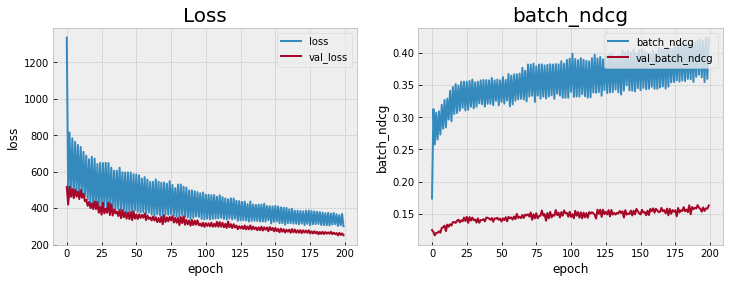

In [30]:
show_history(total_hist, 'loss', 'batch_ndcg')

In [31]:
pred = test_predictor(test_q, model, n_item, batch_size, N = 100)
pred.head(5)

,userId,movieId
0,4,"[246, 23, 167, 134, 669, 38, 766, 0, 486, 48, ..."
1,9,"[10, 44, 124, 1256, 19, 385, 26, 14, 167, 814,..."
2,14,"[97, 128, 317, 515, 244, 184, 124, 116, 189, 2..."
3,44,"[104, 51, 167, 23, 128, 134, 420, 0, 246, 669,..."
4,59,"[44, 22, 64, 124, 104, 127, 38, 48, 113, 189, ..."


In [32]:
eval = evaluate(test_a, pred)

eval(K = 20)
eval.print_all()

eval(K = 100)
eval.print_all()


      Recall@20 : 0.12235 
   Precision@20 : 0.07839 
         MAP@20 : 0.03991 
         nRR@20 : 0.23178 
        nDCG@20 : 0.10925



      Recall@100 : 0.30466 
   Precision@100 : 0.05038 
         MAP@100 : 0.05025 
         nRR@100 : 0.23792 
        nDCG@100 : 0.18221


### 3. Mult-DAE

In [33]:
def DAE(n_user: int,
        n_item: int,
        latent_dim = 200,
        activation = 'tanh',
        optimizer = 'adam',
        dropout_rate = 0.5,
        kernel_initializer = None,
        kernel_regularizer = None) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.0001)
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dropout(dropout_rate)(x)
    x = Dense(latent_dim, activation = activation, kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'encoder')(x)
    outputs = Dense(n_item, activation = 'softmax', kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, name = 'decoder')(x)
    model = Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = optimizer, loss = log_loss, metrics = [mae, batch_ndcg])
    return model

In [34]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-6)
model = DAE(n_user, n_item, latent_dim = 200, optimizer = optimizer)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3706)              0         
_________________________________________________________________
encoder (Dense)              (None, 200)               741400    
_________________________________________________________________
decoder (Dense)              (None, 3706)              744906    
Total params: 1,486,306
Trainable params: 1,486,306
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time
epochs = 200
early_stopping = EarlyStopping(monitor = 'val_batch_ndcg', mode = 'max', verbose = 1, patience = 20)
model_checkpoint = ModelCheckpoint(f'Mult-DAE.h5', monitor = 'val_batch_ndcg', mode = 'max', save_best_only = True)
hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps,
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/200
38/38 [==============================] - 1s 15ms/step - loss: 728.4081 - mae: 0.0263 - batch_ndcg: 0.2717 - val_loss: -375.5182 - val_mae: 0.0247 - val_batch_ndcg: 0.1525
Epoch 2/200
38/38 [==============================] - 0s 12ms/step - loss: 680.5502 - mae: 0.0259 - batch_ndcg: 0.4351 - val_loss: -361.9391 - val_mae: 0.0247 - val_batch_ndcg: 0.1779
Epoch 3/200
38/38 [==============================] - 0s 11ms/step - loss: 690.5867 - mae: 0.0269 - batch_ndcg: 0.5078 - val_loss: -351.8665 - val_mae: 0.0247 - val_batch_ndcg: 0.1926
Epoch 4/200
38/38 [==============================] - 1s 14ms/step - loss: 663.9103 - mae: 0.0263 - batch_ndcg: 0.5494 - val_loss: -345.1814 - val_mae: 0.0247 - val_batch_ndcg: 0.2028
Epoch 5/200
38/38 [==============================] - 0s 13ms/step - loss: 659.8081 - mae: 0.0265 - batch_ndcg: 0.5821 - val_loss: -340.4692 - val_mae: 0.0247 - val_batch_ndcg: 0.2055
Epoch 6/200
38/38 [==============================] - 0s 13ms/step - loss: 654.7893 - 

In [36]:
pred = test_predictor(test_q, model, n_item, batch_size, N = 100)
pred.head(5)

,userId,movieId
0,4,"[246, 435, 515, 958, 357, 134, 23, 38, 524, 54..."
1,9,"[19, 44, 206, 632, 676, 124, 643, 41, 1345, 13..."
2,14,"[195, 501, 891, 164, 97, 128, 39, 150, 74, 317..."
3,44,"[134, 547, 865, 723, 1194, 396, 690, 412, 171,..."
4,59,"[113, 189, 38, 166, 195, 160, 50, 64, 104, 48,..."


In [37]:
eval = evaluate(test_a, pred)

eval(K = 20)
eval.print_all()

eval(K = 100)
eval.print_all()


      Recall@20 : 0.14544 
   Precision@20 : 0.07674 
         MAP@20 : 0.04604 
         nRR@20 : 0.22107 
        nDCG@20 : 0.11967



      Recall@100 : 0.39622 
   Precision@100 : 0.05579 
         MAP@100 : 0.06325 
         nRR@100 : 0.22866 
        nDCG@100 : 0.21966
